In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

In [3]:
#Reading data
raw = mne.io.read_raw_nihon('data/FA330022.EEG', preload=True)

Loading FA330022.EEG
Reading header from /home/pablo/Documents/Universidad Data/Maestría en Matemáticas Aplicadas/Tesis/data/FA330022.EEG
Reading 0 ... 299499  =      0.000 ...   598.998 secs...


/tmp/ipykernel_10059/1819702910.py:2: RuntimeWarning: No PNT file exists. Metadata will be blank
  raw = mne.io.read_raw_nihon('/home/pablo/Documents/Universidad Data/Maestría en Matemáticas Aplicadas/Tesis/data/FA330022.EEG', preload=True)
/tmp/ipykernel_10059/1819702910.py:2: RuntimeWarning: No LOG file exists. Annotations will not be read
  raw = mne.io.read_raw_nihon('/home/pablo/Documents/Universidad Data/Maestría en Matemáticas Aplicadas/Tesis/data/FA330022.EEG', preload=True)


In [4]:
#Pick only EEG channels
raw.pick_types(eeg=True, bio=False, misc=False)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,23 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,500.00 Hz
Highpass,0.00 Hz
Lowpass,250.00 Hz


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)


/tmp/ipykernel_10059/3880221071.py:6: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(fmax=50)
/home/pablo/Documents/Universidad Data/Maestría en Matemáticas Aplicadas/Tesis/environment/lib/python3.10/site-packages/mne/viz/utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


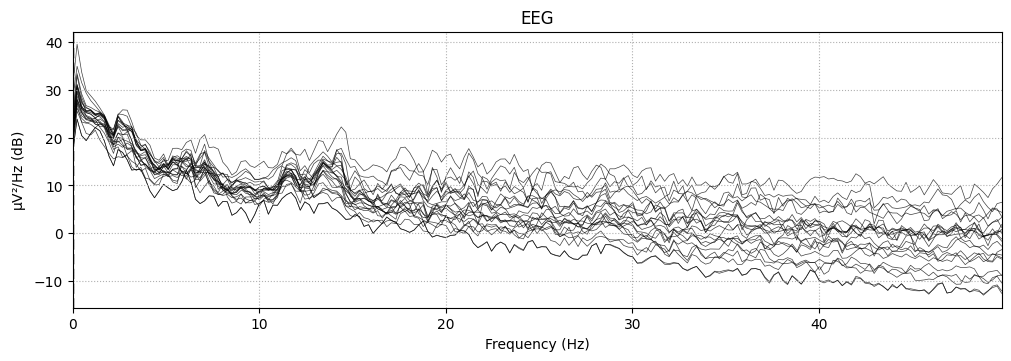

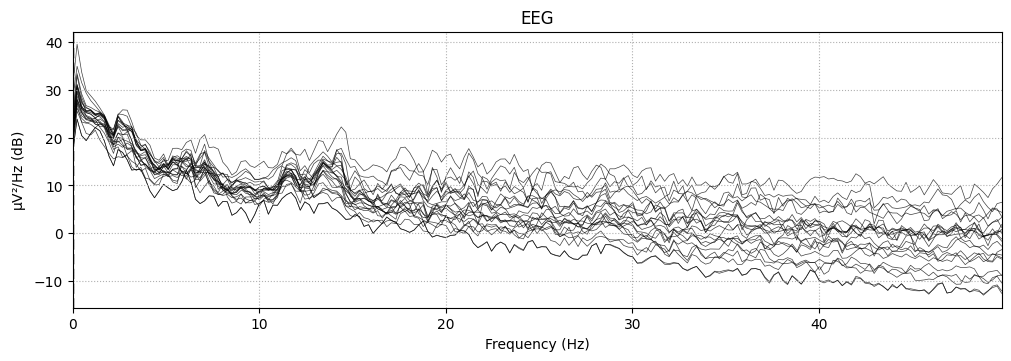

In [5]:
#Channels list
channels = raw.ch_names
channels_to_remove=['E']
raw.drop_channels(channels_to_remove)

raw.plot_psd(fmax=50)

In [7]:
# Step 4: Filtering
raw.filter(l_freq = 0, h_freq = 97.0)
# Set the frequency you want to remove; it's commonly 50 Hz or 60 Hz
notch_freq = 60  # or 60 for the USA and other countries using 60Hz
# Apply notch filter
raw.notch_filter(freqs = notch_freq)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 97 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 97.00 Hz
- Upper transition bandwidth: 24.25 Hz (-6 dB cutoff frequency: 109.12 Hz)
- Filter length: 69 samples (0.138 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 3301 sa

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,22 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,500.00 Hz
Highpass,0.00 Hz
Lowpass,97.00 Hz


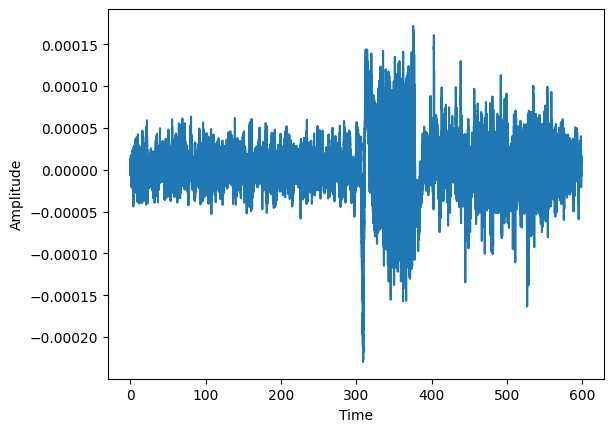

In [10]:
data=raw.get_data()[6]
#Sampling signal at 500 Hz
fs=500
#Sampling period
T=1/fs
#Length of signal
L=len(data)
#Time vector
t=np.arange(0,L)*T
#Plotting signal
plt.plot(t,data)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

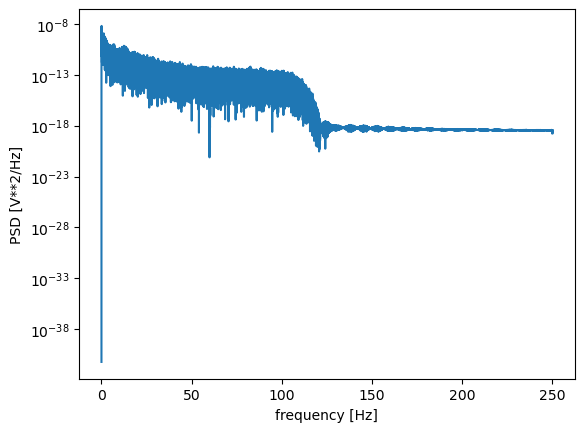

In [95]:
#Getting the energy spectral density gammma(w)=(X(w)*X(w))/2pi where X(w) is the fourier transform of x(t)
#and x(t) is the signal. Using the periodogram method
#Getting the periodogram of the signal data
f, Pxx_den = signal.periodogram(data,fs=raw.info['sfreq'],scaling='density')
#plotting the periodogram
plt.semilogy(f, Pxx_den)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

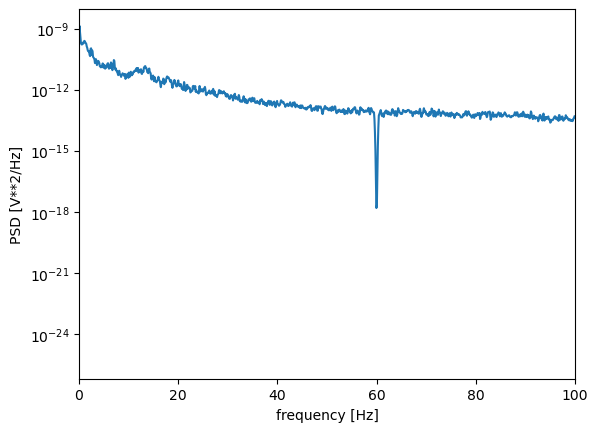

In [96]:
(f, S)= signal.welch(data, fs=raw.info['sfreq'], nperseg=1024*5)

plt.semilogy(f, S)
plt.xlim([0, 100])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

In [72]:
# #Getting the ER values for every frequency band
# ETheta = np.sum(S[np.where((f>=3.5) & (f<7.4))])   
# EAlpha = np.sum(S[np.where((f>=7.4) & (f<12.4))])
# EBeta = np.sum(S[np.where((f>=12.4) & (f<24))])
# EGamma = np.sum(S[np.where((f>=24) & (f<=97))])

# ER= (EBeta + EGamma)/(ETheta + EAlpha)
# print(ER)

1.425705371965328


In [53]:
def calculate_ER(data, window_size, overlap):
    """
    Calculate time-varying Energy Ratio (ER) from Theta(w) using a sliding window.

    Parameters:
    - S: Periodogram estimate for Theta(w)
    - f: Frequency vector
    - window_size: Size of the sliding window in samples
    - overlap: Overlap between consecutive windows in samples

    Returns:
    - time_points: Array of time points corresponding to the center of each window
    - ER_values: Array of time-varying ER values
    """

    # Initialize empty arrays to store results
    time_points = []
    ER_values = []

    # Iterate through the signal with the sliding window
    for start in range(0, len(data) - window_size + 1, overlap):
        end = start + window_size
        (f, S)= signal.welch(data[start:end], fs=raw.info['sfreq'], nperseg=1024*5)
        #(f,S)=signal.periodogram(data[start:end],fs=raw.info['sfreq'],scaling='density')

        # Calculate energy in each frequency band for the current window
        ETheta = np.sum(S[np.where((f >= 3.5) & (f < 7.4))])
        EAlpha = np.sum(S[np.where((f >= 7.4) & (f < 12.4))])
        EBeta = np.sum(S[np.where((f >= 12.4) & (f < 24))])
        EGamma = np.sum(S[np.where((f >= 24) & (f <= 97))])

        # Calculate Energy Ratio (ER) for the current window
        ER = (EBeta + EGamma) / (ETheta + EAlpha)

        # Store results
        time_points.append((start + end) / 2)  # Use the center of the window as the time point
        ER_values.append(ER)

    return np.array(time_points), np.array(ER_values)

# Example usage

window_size = 50#Adjust as needed
overlap = 7  # Adjust as needed
time_points, ER_values = calculate_ER(data, window_size, overlap)


/home/pablo/Documents/Universidad Data/Maestría en Matemáticas Aplicadas/Tesis/environment/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 5120 is greater than input length  = 50, using nperseg = 50
  warnings.warn('nperseg = {0:d} is greater than input length '


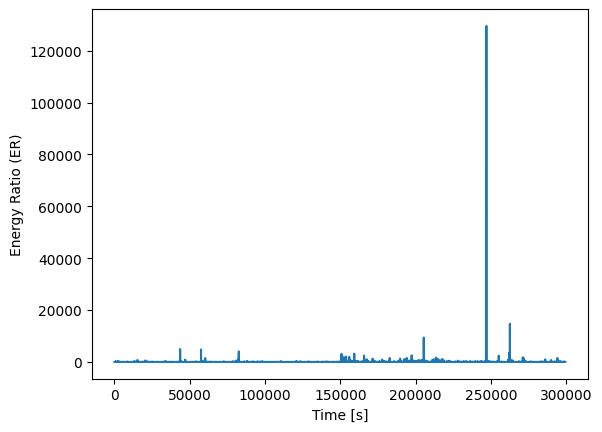

In [54]:
#Plotting the ER values
plt.plot(time_points, ER_values)
plt.xlabel('Time [s]')
plt.ylabel('Energy Ratio (ER)')
plt.show()


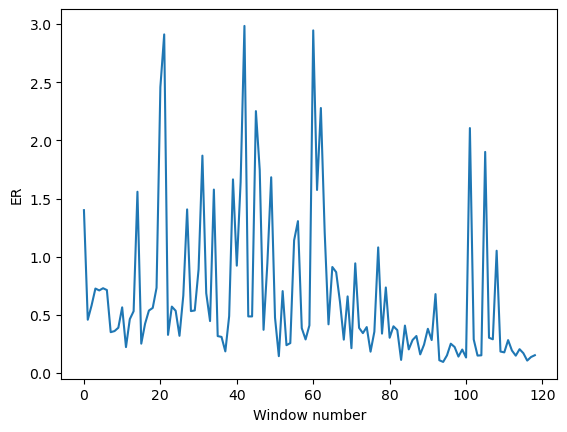

In [98]:
##Getting ER[n] using the periodogram method with sliding windowsn=k*delta where k is the window number and delta is the window shift
k=5
delta=k*T
ER=np.zeros(int(L/(k*fs))) 
#Number of samples in the window
n=int(k*fs)
#Window length
N=int(L/n)

for i in range(N):
    #Getting the window
    window=data[i*n:(i+1)*n]
    #Getting the periodogram of the window
    (f, S)= signal.welch(window, fs=raw.info['sfreq'], nperseg=n)
    #Getting the ER values for every frequency band
    ETheta = np.sum(S[np.where((f>=3.5) & (f<7.4))])   
    EAlpha = np.sum(S[np.where((f>=7.4) & (f<12.4))])
    EBeta = np.sum(S[np.where((f>=12.4) & (f<24))])
    EGamma = np.sum(S[np.where((f>=24) & (f<=97))])
    ER[i] = (EBeta + EGamma)/(ETheta + EAlpha)
plt.plot(ER)
plt.xlabel('Window number')
plt.ylabel('ER')
plt.show()


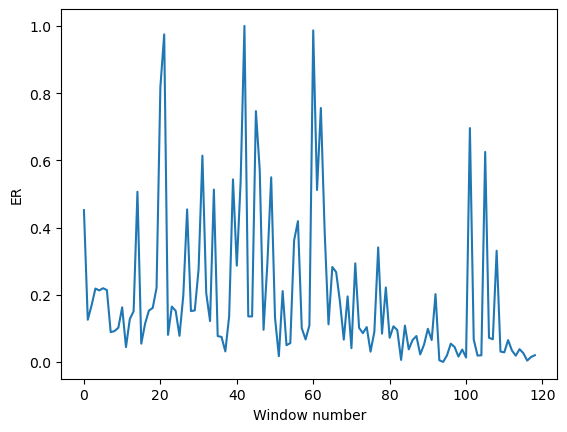

In [99]:
#Normalize between 0 and 1
ER = (ER - np.min(ER))/(np.max(ER)-np.min(ER))
plt.plot(ER)
plt.xlabel('Window number')
plt.ylabel('ER')
plt.show()

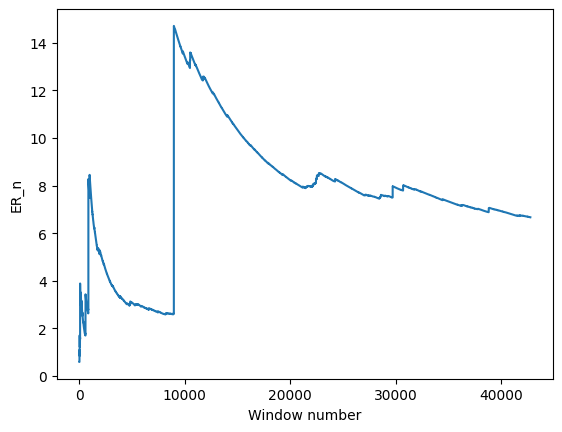

In [32]:
ER=ER_values
N=len(ER)
ER_n=np.zeros(len(ER))
#A loop from the second window to the last one
ER_n[0]=ER[0]
for i in range(1,N):
    ER_n[i]=(1/i)*np.sum(ER[0:i])
plt.plot(ER_n)
plt.xlabel('Window number')
plt.ylabel('ER_n')
plt.show()

The local minimum of U_n is:  99230.66659114201
The lambda value is:  0.5
The change points are:  (array([], dtype=int64),)


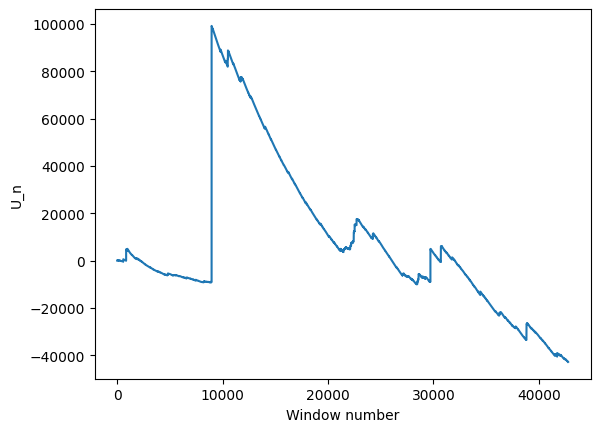

In [40]:
#Finding the minimum local of U_n
u_max=np.max(U_n)
print("The local minimum of U_n is: ",u_max)
#Now, the H_O is the null hypothesis that : no change has ocurred in ER
#The null mhypothesis is rejected if (U_n-u_min)>lambda
#The lambda value is the threshold
#Getting the lambda value
lambda_value=0.
print("The lambda value is: ",lambda_value)
#Getting the change points
change_points=np.where(U_n-u_max>lambda_value)
print("The change points are: ",change_points)
#Plotting the change points
plt.plot(U_n)
plt.plot(change_points[0],U_n[change_points[0]],'ro')
plt.xlabel('Window number')
plt.ylabel('U_n')
plt.show()

In [47]:
#Making a matrix of U_n, where the rows are every channel and the columns are the windows
#Getting the channels
channels = raw.ch_names
#Getting the number of channels
n_channels=len(channels)
#Getting the number of windows
n_windows=len(U_n)
#Making a matrix of zeros
U_n_matrix=np.zeros((n_channels,n_windows))
#A loop for every channel
for k in range(n_channels):
    #Getting the data of the channel
    data=raw.get_data()[k]
    #Getting the ER values
    time_points, ER_values = calculate_ER(data, window_size, overlap)
    ER=ER_values
    N=len(ER)
    ER_n=np.zeros(len(ER))
    #A loop from the second window to the last one
    ER_n[0]=ER[0]
    for i in range(1,N):
        ER_n[i]=(1/i)*np.sum(ER[0:i])
    ##Getting U_n
    U_n=np.zeros(len(ER))
    v=0.1
    for i in range(N):
        U_n[i]=np.sum(ER[0:i]-ER_n[0:i]-0.1)
    #Saving the U_n values in the matrix
    U_n_matrix[k,:]=U_n

/home/pablo/Documents/Universidad Data/Maestría en Matemáticas Aplicadas/Tesis/environment/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 5120 is greater than input length  = 50, using nperseg = 50
  warnings.warn('nperseg = {0:d} is greater than input length '


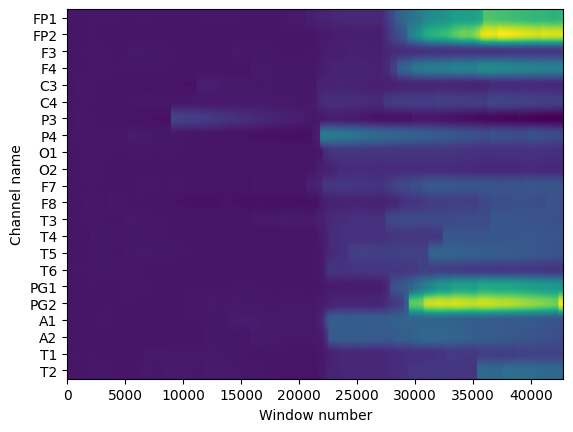

In [50]:
#Plotting the U_n values for every in a heatmap with an x axis of the window number and a y axis of the channel name with imshow variable "channels" as the labels
plt.imshow(U_n_matrix,aspect='auto')
plt.yticks(np.arange(len(channels)), channels)
plt.xlabel('Window number')
plt.ylabel('Channel name')
plt.show()